In [1]:
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from PIL import Image
from tensorflow import keras
from glob import glob
import pandas as pd
import imutils
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import argparse
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

# 2차로 추가로 받은 데이터입니다

## imp = Rp

## imp > 10000 인 데이터 삭제

# Data Pre-processing

In [2]:
#각 엑셀 파일에서 Rp, Rs 값 추출

file_names_list = []
imp_list = []
dir = "data_files/0713/excel_files"

for file in os.listdir(dir):
    file_name = dir + "/" + file
    f = open(file_name,'r', encoding='UTF8')
    rdr = list(csv.reader(f))
    Rp = round(float(rdr[120][8])/5, 3)
    #Rs = round(float(rdr[120][10])/5, 3)
    imp = Rp
    if imp > 10000:
        continue
    file_names_list.append(file.split("_")[1].replace(" ", "").replace(",", "").replace(".", ""))
    imp_list.append(imp)
    
    print("file : ", file, "    imp : ", imp)
    
    f.close()


file :  Generic C-f [(1) _30, 1, no.6_; 7_3_2023 1_46_05 PM].csv     imp :  5231.247
file :  Generic C-f [(1) _40, 1, no.5_; 7_3_2023 1_26_50 PM].csv     imp :  3377.876
file :  Generic C-f [(10) _40, 3, no.5_; 7_3_2023 1_30_34 PM].csv     imp :  8857.827
file :  Generic C-f [(10) _70, 3, no.5_; 7_3_2023 12_16_08 PM].csv     imp :  1945.563
file :  Generic C-f [(100) _60, 7, no.6_; 7_3_2023 12_51_06 PM].csv     imp :  3908.265
file :  Generic C-f [(104) _60, 9, no.1_; 7_3_2023 12_52_21 PM].csv     imp :  7000.179
file :  Generic C-f [(105) _60, 9, no.2_; 7_3_2023 12_53_00 PM].csv     imp :  4737.585
file :  Generic C-f [(106) _60, 9, no.3_; 7_3_2023 12_53_29 PM].csv     imp :  3954.343
file :  Generic C-f [(11) _70, 3, no.6_; 7_3_2023 12_16_39 PM].csv     imp :  1859.064
file :  Generic C-f [(110) _60, 9, no.4_; 7_3_2023 12_54_13 PM].csv     imp :  4746.952
file :  Generic C-f [(111) _60, 9, no.5_; 7_3_2023 12_54_41 PM].csv     imp :  4164.22
file :  Generic C-f [(112) _60, 9, no.6_; 7

In [3]:
# save cropped images with impedance values on their file names

In [4]:
ground_dir = "data_files/0713/"
image_dir = ground_dir + "images"
make_dir = ground_dir + "processed_images_Rp"
os.makedirs(make_dir)

count = 0

for file in os.listdir(image_dir):
    
    original_image_name = file[:-4].replace(" ", "").replace(",", "").replace(".", "")
    
    try:
        imp_index = file_names_list.index(original_image_name)
    except ValueError:
        print("cannot find excel file for : " + file)
        continue
     
    new_image_name = imp_list[imp_index]
    image = load_img(image_dir + "/" + file)
    cropped_image = image.crop((0,448,2560,1472))
    cropped_image.save(make_dir + "/" + str(new_image_name) + ".jpg")
    
    count += 1
    
print("saved " + str(count) + " images")

cannot find excel file for : 30, 3, no.1.jpg
cannot find excel file for : 30, 3, no.2.jpg
cannot find excel file for : 30, 3, no.3.jpg
cannot find excel file for : 30, 3, no.4.jpg
cannot find excel file for : 30, 3, no.5.jpg
cannot find excel file for : 30, 3, no.6.jpg
cannot find excel file for : 30, 3, no.7.jpg
cannot find excel file for : 30, 5, no.1.jpg
cannot find excel file for : 30, 5, no.2.jpg
cannot find excel file for : 30, 5, no.3.jpg
cannot find excel file for : 30, 5, no.4.jpg
cannot find excel file for : 30, 5, no.5.jpg
cannot find excel file for : 30, 5, no.6.jpg
cannot find excel file for : 30, 5, no.7.jpg
cannot find excel file for : 30, 7, no.1.jpg
cannot find excel file for : 30, 7, no.2.jpg
cannot find excel file for : 30, 7, no.3.jpg
cannot find excel file for : 30, 7, no.4.jpg
cannot find excel file for : 40, 3, no.3.jpg
cannot find excel file for : 40, 3, no.6.jpg
cannot find excel file for : 40, 3, no.7.jpg
cannot find excel file for : 40, 5, no.1.jpg
cannot fin

# CNN Training

In [2]:
ground_dir = "data_files/0713/"
image_dir = ground_dir + "images"
make_dir = ground_dir + "processed_images_Rp"

In [3]:
# 학습용 이미지 쪼개기
# 저장된 이미지는 (1024*2560)

image_width = 512
image_height = 1024
rows = 1
columns = 1

X = []
Y = []

for file_name in os.listdir(make_dir):
    if file_name != '.DS_Store':
        image = Image.open(make_dir+"/"+file_name).convert("L")
        for j in range(rows):

            for i in range(columns):
                cropped = image.crop((i*image_width,j*image_height,(i+1)*image_width,(j+1)*image_height))
                cropped = np.array(cropped)
                X.append(cropped)
                Y.append(int(float(file_name[:-4])))

In [4]:
X = np.array(X)/255.0
Y = np.array(Y)
print(X.shape, Y.shape)

(278, 1024, 512) (278,)


In [5]:
standard_scaler_y = StandardScaler()
reshape_y = Y.reshape(-1,1)
reshape_y = standard_scaler_y.fit_transform(reshape_y)

In [6]:
test_size = 0.2
shuffle = True
random_state = 42

train_x, test_x, train_y, test_y = train_test_split(X, reshape_y, test_size=test_size, shuffle=shuffle, random_state=random_state)

In [7]:
# callback
patience=20
early_stopping_cb = EarlyStopping(patience=patience, restore_best_weights=True, monitor='val_loss')

In [8]:
train_x_cnn = train_x[..., np.newaxis]
test_x_cnn = test_x[..., np.newaxis]

In [9]:
train_x_cnn.shape

(222, 1024, 512, 1)

In [10]:
train_y.shape

(222, 1)

In [11]:

# sequential model
cnn_model = keras.models.Sequential()

# input and convolutional layer
cnn_model.add(keras.layers.Conv2D(32, 7, activation='relu', padding='same',
                                  input_shape=[1024, 512, 1]))
# pooling layer
cnn_model.add(keras.layers.MaxPooling2D(2))

# convolutional layers and pooling layer
cnn_model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.MaxPooling2D(2))

# convolutional layers and pooling layer
cnn_model.add(keras.layers.Conv2D(128, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.Conv2D(128, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.MaxPooling2D(2))

# flatten layer
cnn_model.add(keras.layers.Flatten())

# dense layers
cnn_model.add(keras.layers.Dense(64, activation='relu'))
cnn_model.add(keras.layers.Dense(32, activation='relu'))

# output layer
cnn_model.add(keras.layers.Dense(1))

# model complie
cnn_model.compile(optimizer='adam',loss='mse')

In [12]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1024, 512, 32)     1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 256, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 256, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 512, 256, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 256, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 128, 128)     7

In [13]:
path_directory = make_dir + ".h5"
istrue = os.path.exists(path_directory)

if not istrue:
    history = cnn_model.fit(train_x_cnn, train_y, callbacks=[early_stopping_cb],
                            epochs=100, validation_split=0.2)
    cnn_model.save(path_directory)
    print("model is saved")
else:
    cnn_model = keras.models.load_model(path_directory)
    print("model is loaded")

Epoch 1/100
6/6 [==============================] - 17s 2s/step - loss: 6.7971 - val_loss: 1.2259
Epoch 2/100
6/6 [==============================] - 2s 387ms/step - loss: 0.9325 - val_loss: 1.1545
Epoch 3/100
6/6 [==============================] - 2s 360ms/step - loss: 0.9383 - val_loss: 1.1894
Epoch 4/100
6/6 [==============================] - 2s 355ms/step - loss: 0.9193 - val_loss: 1.1882
Epoch 5/100
6/6 [==============================] - 2s 358ms/step - loss: 0.9206 - val_loss: 1.1900
Epoch 6/100
6/6 [==============================] - 2s 352ms/step - loss: 0.9175 - val_loss: 1.1915
Epoch 7/100
6/6 [==============================] - 2s 356ms/step - loss: 0.9162 - val_loss: 1.1889
Epoch 8/100
6/6 [==============================] - 2s 376ms/step - loss: 0.9101 - val_loss: 1.1203
Epoch 9/100
6/6 [==============================] - 2s 354ms/step - loss: 0.8646 - val_loss: 1.3372
Epoch 10/100
6/6 [==============================] - 2s 381ms/step - loss: 0.8079 - val_loss: 0.8423
Epoch 11/10

6/6 [==============================] - 2s 357ms/step - loss: 0.1008 - val_loss: 0.2151
Epoch 84/100
6/6 [==============================] - 2s 382ms/step - loss: 0.1192 - val_loss: 0.1439
Epoch 85/100
6/6 [==============================] - 2s 354ms/step - loss: 0.0864 - val_loss: 0.1460
Epoch 86/100
6/6 [==============================] - 2s 356ms/step - loss: 0.0876 - val_loss: 0.1473
Epoch 87/100
6/6 [==============================] - 2s 357ms/step - loss: 0.0825 - val_loss: 0.1730
Epoch 88/100
6/6 [==============================] - 2s 358ms/step - loss: 0.0917 - val_loss: 0.1479
Epoch 89/100
6/6 [==============================] - 2s 382ms/step - loss: 0.0820 - val_loss: 0.1390
Epoch 90/100
6/6 [==============================] - 2s 356ms/step - loss: 0.0833 - val_loss: 0.1443
Epoch 91/100
6/6 [==============================] - 2s 359ms/step - loss: 0.0888 - val_loss: 0.1482
Epoch 92/100
6/6 [==============================] - 2s 357ms/step - loss: 0.0796 - val_loss: 0.1424
Epoch 93/100


# Results

In [14]:
print(cnn_model.evaluate(train_x_cnn, train_y))


7/7 [==============================] - 2s 231ms/step - loss: 0.1182
0.1182105615735054


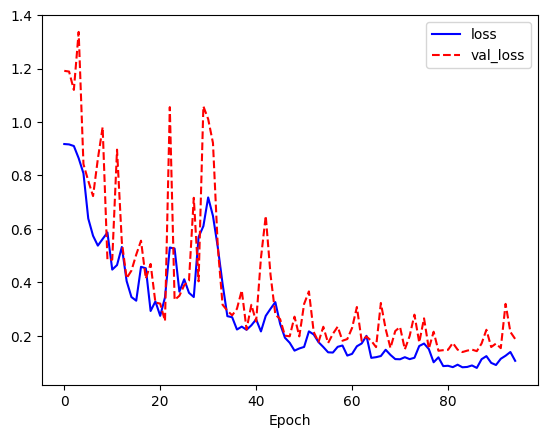

In [15]:
plt.plot(history.history['loss'][5:], 'b-', label='loss')
plt.plot(history.history['val_loss'][5:], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

2/2 [==============================] - 2s 2s/step


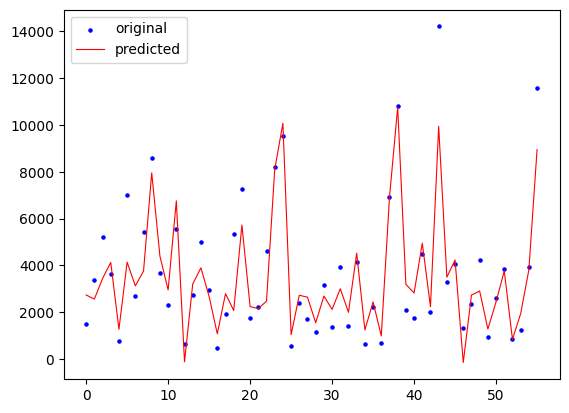

In [16]:
pred = cnn_model.predict(test_x)
inv_test_y = standard_scaler_y.inverse_transform(test_y)
inv_pred = standard_scaler_y.inverse_transform(pred)

x_ax = range(len(inv_pred))
plt.scatter(x_ax, inv_test_y, s=5, color="blue", label="original")
plt.plot(x_ax, inv_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [17]:
print("RMSE: %.4f" % mean_squared_error(inv_test_y, inv_pred)**(1/2))

RMSE: 1177.6885
